In [ ]:
import networkx as nx
from networkx import algorithms
from networkx.algorithms import community
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import numpy as np
import os
import time
import operator

In [ ]:
# Set base directory
base_dir = os.getcwd()  # Set to current working directory

print(base_dir)

# Set the path to vrp-matrices directory
vrp_matrices_dir = os.path.join(base_dir, 'vrp-matrices')

# Full path to the .npz file
npz_file_path = os.path.join(vrp_matrices_dir, 'test_pb_27_.npz')  # Replace 'test_pb_27_.npz' with the actual file name

# Check if the file exists
if not os.path.isfile(npz_file_path):
    raise FileNotFoundError(f"No such file or directory: '{npz_file_path}'")

# Load Q matrix from .npz file
data = np.load(npz_file_path)
Q = data['Q']

# Convert Q matrix to graph
G = nx.Graph()

# Add edges to the graph
n = Q.shape[0]
for i in range(n):
    for j in range(i+1, n):
        if Q[i, j] != 0:
            G.add_edge(i, j, weight=Q[i, j])

# Set color variables for plotting
gray = '#8C8C8C'
green = '#76B900'

# Set the position of the nodes so that the graph is easily recognizable each time it's plotted
pos = nx.spring_layout(G, seed=12345)

# Plot the graph
color_map = [green] * G.number_of_nodes()
nx.draw(G, with_labels=True, pos=pos, node_color=color_map, edge_color=gray)

plt.show()

FileNotFoundError: No such file or directory: '/mnt/c/Users/rames102/AppData/Local/Programs/Microsoft VS Code/vrp-matrices/test_pb_27_.npz'

In [71]:
# Identifying and setting target
targets = cudaq.get_targets()
# for target in targets:
#    print(target)
cudaq.set_target("qpp-cpu") # nvidia-fp64
target = cudaq.get_target()

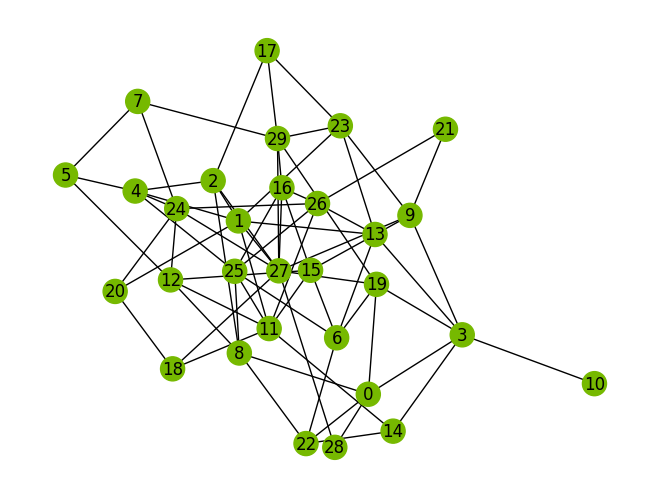

In [ ]:
# Graph Definition

n = 30  # numnber of nodes
# Once you've completed the lab, try increasing the number of nodes to 40
m = 70  # number of edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
sampleGraph2 = nx.gnm_random_graph(n, m, seed=seed)

# Set color variables for plotting
gray ='#8C8C8C'
green ='#76B900'

# Set the position of the nodes so that the graph is easily recognizable each time it's plotted
pos = nx.spring_layout(sampleGraph2, seed=12345)

# Plot example graph for which we will be trying to compute the max cut
color_map = [green]* sampleGraph2.number_of_nodes()
nx.draw(sampleGraph2, with_labels=True, pos = pos, node_color=color_map)

#plt.savefig('sampleGraph2.png')
plt.show()



In [73]:
# Define a function to generate the Hamiltonian for a max cut problem using the graph G

def hamiltonian_max_cut(sources : List[int], targets : List[int]):
    """Hamiltonian for finding the max cut for the graph  with edges defined by the pairs generated by source and target edges

    Parameters
    ----------
    sources: List[int]
        list of the source vertices for edges in the graph
    targets: List[int]
        list of the target vertices for the edges in the graph

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph defined by the given edges
    """
    hamiltonian = 0
    # Since our vertices may not be a list from 0 to n, or may not even be integers,

    for i in range(len(sources)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = sources[i]
        qubitv = targets[i]
        hamiltonian += 0.5*(spin.z(qubitu)*spin.z(qubitv)-spin.i(qubitu)*spin.i(qubitv))

    return hamiltonian

In [74]:
# QAOA kernels

# Problem kernel
@cudaq.kernel
def qaoaProblem(qubit_0 : cudaq.qubit, qubit_1 : cudaq.qubit, alpha : float):
    """Build the QAOA gate sequence between two qubits that represent an edge of the graph
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit representing the first vertex of an edge
    qubit_1: cudaq.qubit
        Qubit representing the second vertex of an edge
    alpha: float
        Free variable

    """
    x.ctrl(qubit_0, qubit_1)
    rz(2.0*alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

# Mixer kernel
@cudaq.kernel
def qaoaMixer(qubit_0 : cudaq.qubit, beta : float):
    """Build the QAOA gate sequence that is applied to each qubit in the mixer portion of the circuit
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit
    beta: float
        Free variable

    """
    rx(2.0*beta, qubit_0)

In [75]:
# Define the QAOA circuit: # The QAOA circuit for max cut depends on the structure of the graph!

@cudaq.kernel
def kernel_qaoa(qubit_count :int, layer_count: int, edges_src: List[int], edges_tgt: List[int], thetas : List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized

    """

    # Allocate qubits
    qreg = cudaq.qvector(qubit_count)

    # Placing qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add mixer kernel to each layer
        for j in range(qubit_count):
            qaoaMixer(qreg[j], thetas[layer_count + i])          

In [76]:
# Find the optimal parameters for the QAOA circuit using classical optimization

def find_optimal_parameters(G, layer_count, seed):
    """Function for finding the optimal parameters of QAOA for the max cut of a graph
    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    list[float]
        Optimal parameters for the QAOA applied to the given graph G
    """
    parameter_count = 2*layer_count

    # Problem parameters
    nodes = sorted(list(G.nodes()))
    qubit_src = []
    qubit_tgt = []

    for u,v in nx.edges(G):
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
    # The number of qubits is equal to the number of nodes in the graph
    qubit_count: int = len(nodes)
    # Each layer has two parameters: one for the problem kernel and one for the mixer
    parameter_count: int = 2*layer_count

    # Specifiy the classical otpimizer and the initial parameters
    optimizer = cudaq.optimizers.COBYLA()
    np.random.seed(seed)
    optimizer.initial_parameters = np.random.uniform(-np.pi, np.pi, parameter_count)

    # Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
    optimal_expectation, optimal_parameters = cudaq.vqe(
        kernel=kernel_qaoa,
        spin_operator=hamiltonian_max_cut(qubit_src, qubit_tgt),
        argument_mapper=lambda parameter_vector: (qubit_count, layer_count, qubit_src, qubit_tgt, parameter_vector),
        optimizer=optimizer,
        parameter_count=parameter_count)

    return optimal_parameters

In [77]:
# These function from Lab 2 are used to identify the subgraph
# that contains a given vertex, and identify the vertices of the parent graph
# that lie on the border of the subgraphs in the subgraph dictionary

def subgraph_of_vertex(graph_dictionary, vertex):
    """
    A function that takes as input a subgraph partition (in the form of a graph dictionary) and a vertex.
    The function should return the key associated with the subgraph that contains the given vertex.

    Parameters
    ----------
    graph_dictionary: dict of networkX.Graph with str as keys
    v : int
        v is a name for a vertex
    Returns
    -------
    str
        the key associated with the subgraph that contains the given vertex.
    """
    # in case a vertex does not appear in the graph_dictionary, return the empty string
    location = ''

    for key in graph_dictionary:
        if vertex in graph_dictionary[key].nodes():
            location = key
    return location

def border(G, subgraph_dictionary):
    """Build a graph made up of border vertices from the subgraph partition

    Parameters
    ----------
    G: networkX.Graph
        Graph whose max cut we want to find
    subgraph_dictionary: dict of networkX graph with str as keys
        Each graph in the dictionary should be a subgraph of G

    Returns
    -------
    networkX.Graph
        Subgraph of G made up of only the edges connecting subgraphs in the subgraph dictionary
    """
    borderGraph = nx.Graph()
    for u,v in G.edges():
        border = True
        for key in subgraph_dictionary:
            SubG = subgraph_dictionary[key]
            edges = list(nx.edges(SubG))
            if (u,v) in edges:
                border = False
        if border==True:
            borderGraph.add_edge(u,v)

    return borderGraph

In [78]:
def qaoa_for_graph(G, layer_count, shots, seed):
    """Function for finding the max cut of a graph using QAOA

    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    shots : int
        Number of shots in the sampling subroutine
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    str
        Binary string representing the max cut coloring of the vertinces of the graph
    """
    parameter_count: int = 2 * layer_count

    # Problem parameters
    nodes = sorted(list(nx.nodes(G)))
    qubit_src = []
    qubit_tgt = []
    for u, v in nx.edges(G):
        # We can use the index() command to read out the qubits associated with the vertex u and v.
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
    # The number of qubits we'll need is the same as the number of vertices in our graph
    qubit_count : int = len(nodes)
    # Each layer of the QAOA kernel contains 2 parameters
    parameter_count : int = 2*layer_count

    optimal_parameters = find_optimal_parameters(G, layer_count, seed)

    # Print the optimized parameters
    print("Optimal parameters = ", optimal_parameters)

    # Sample the circuit
    counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots)
    print('most_probable outcome = ',counts.most_probable())
    results = str(counts.most_probable())
    return results

In [79]:
# QAOA Divide and Conquer: Divide the graph into subgraphs

# Function to return a dictionary of subgraphs of the input graph using the greedy modularity maximization algorithm

def subgraphPartition(G,n):
    """Divide the graph up into at most n subgraphs
    Parameters
    ----------
    G: networkX.Graph
        Graph that we want to subdivide
    n : int
        n is the maximum number of subgraphs in the partition
    Returns
    -------
    dict of str : networkX.Graph
        Dictionary of networkX graphs with a string as the key
    """
    greedy_partition = community.greedy_modularity_communities(G, weight=None, resolution=1.1, cutoff=1, best_n=n)
    number_of_subgraphs = len(greedy_partition)

    graph_dictionary = {}
    graph_names=[]
    for i in range(number_of_subgraphs):
        name='G'+str(i)
        graph_names.append(name)

    for i in range(number_of_subgraphs):
        nodelist = sorted(list(greedy_partition[i]))
        graph_dictionary[graph_names[i]] = nx.subgraph(G, nodelist)

    return(graph_dictionary)

The parent graph is subdivided into 5 subgraphs.
Graph G0 has 8 vertices.
The edges of G0 are [(3, 14), (3, 9), (3, 10), (3, 13), (6, 22), (6, 13), (9, 21), (14, 22)]
The nodes of G0 are [3, 6, 9, 10, 13, 14, 21, 22]
Graph G1 has 7 vertices.
The edges of G1 are [(8, 25), (8, 12), (11, 26), (11, 25), (11, 15), (11, 12), (12, 15), (15, 16), (16, 25), (16, 26), (25, 26)]
The nodes of G1 are [8, 11, 12, 15, 16, 25, 26]
Graph G2 has 6 vertices.
The edges of G2 are [(4, 5), (4, 24), (5, 7), (7, 24), (18, 20), (20, 24)]
The nodes of G2 are [4, 5, 7, 18, 20, 24]
Graph G3 has 5 vertices.
The edges of G3 are [(0, 19), (0, 28), (19, 27), (19, 29), (27, 29), (27, 28)]
The nodes of G3 are [0, 19, 27, 28, 29]
Graph G4 has 4 vertices.
The edges of G4 are [(1, 23), (1, 2), (2, 17), (17, 23)]
The nodes of G4 are [1, 2, 17, 23]


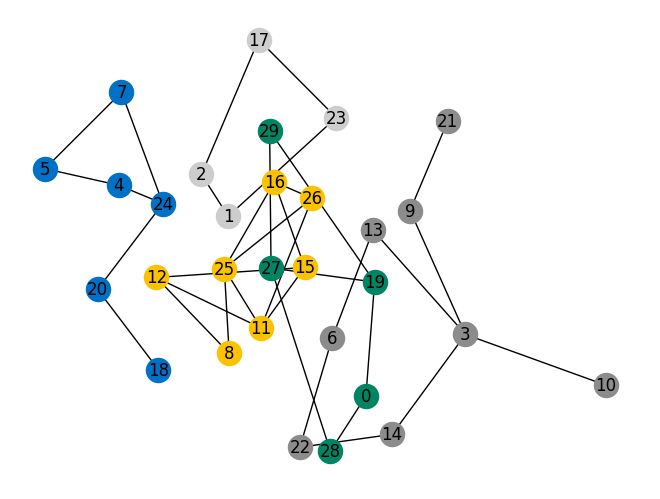

In [80]:
# We plot the subgraphs below in different colors to visualize the subdivision of the graph
# However, edges that connect vertices in distinct subgraphs in subgraph_dictionary are not drawn.

num_subgraphs = min(12, len(sampleGraph2.nodes())) # maximum number of subgraphs for the partition
subgraph_dictionary = subgraphPartition(sampleGraph2,num_subgraphs)

# Adding colors to visualize 7 or fewer subgraphs
blue = '#0071C5'
yellow = '#FAC200'
gray = '#8C8C8C'
emerald = '#008564'
light_gray = '#CDCDCD'
color_list = {}
# Define a multi-color mapping for 7 subgraphs or monochromatic mapping for 8 or more subgraphs
if len(subgraph_dictionary)<8:
    color_list = {"G0":gray, "G1": yellow, "G2": blue, "G3":emerald, "G4": light_gray, "G5": green, "G6":'white'}
else:
    for key in subgraph_dictionary:
        color_list[key] = {green}

# Print the subgraphs and their information
print('The parent graph is subdivided into',len(subgraph_dictionary),'subgraphs.')
for key in subgraph_dictionary:
    print('Graph',key,'has',len(nx.nodes(subgraph_dictionary[key])),'vertices.')
    print('The edges of',key,'are',nx.edges(subgraph_dictionary[key]))
    print('The nodes of',key,'are',nx.nodes(subgraph_dictionary[key]))
    nx.draw(subgraph_dictionary[key], with_labels=True, pos = pos, node_color = color_list[key])
plt.show()

In [81]:
# Identify a subgraph that contains a given vertex

def subgraph_of_vertex(graph_dictionary, vertex):
    """
    A function that takes as input a subgraph partition (in the form of a graph dictionary) and a vertex.
    The function should return the key associated with the subgraph that contains the given vertex.

    Parameters
    ----------
    graph_dictionary: dict of networkX.Graph with str as keys
    v : int
        v is a name for a vertex
    Returns
    -------
    str
        the key associated with the subgraph that contains the given vertex.
    """
    # in case a vertex does not appear in the graph_dictionary, return the empty string
    location = 'Vertex is not in the subgraph_dictionary'

    for key in graph_dictionary:
        if vertex in graph_dictionary[key].nodes():
            location = key
    return location

In [ ]:
# Conquer the subgraphs: Solve the max cut problem for each subgraph. Here, we iterate vqe and sample on each of the subgraphs in the subgraph_dictionary to find the approximate max cut of each of the subgraphs.
# Results for each subgraph are processesd after the result of previous subgraph is obtained. Speed up by running the QAOA for each subgraph in parallel. GPU parallelism is not used in this example.
layer_count = 1
results = {}
new_seed_for_each_graph = 0
shots = 25000
for key in subgraph_dictionary:
    G = subgraph_dictionary[key]
    results[key] = qaoa_for_graph(G, layer_count, shots, seed=653+new_seed_for_each_graph)
    new_seed_for_each_graph+=1
    print('The max cut QAOA coloring for the subgraph',key,'is',results[key])

Optimal parameters =  [0.3813444468104043, 2.751936825839296]
most_probable outcome =  00111001
The max cut QAOA coloring for the subgraph G0 is 00111001
Optimal parameters =  [0.2782533299549024, 1.2262600096652267]
most_probable outcome =  1100100
The max cut QAOA coloring for the subgraph G1 is 1100100
Optimal parameters =  [-1.1605052005625378, 1.1780890193172673]
most_probable outcome =  101110
The max cut QAOA coloring for the subgraph G2 is 101110
Optimal parameters =  [-2.1224721423868984, -2.811280415873026]
most_probable outcome =  00011
The max cut QAOA coloring for the subgraph G3 is 00011
Optimal parameters =  [0.39288282671635955, -0.3927308987741718]
most_probable outcome =  1010
The max cut QAOA coloring for the subgraph G4 is 1010


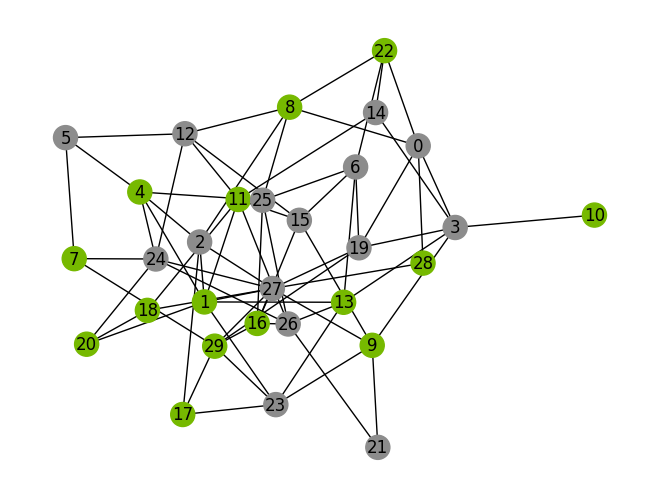

In [84]:
# Merge the subgraphs: Combine the results of the subgraphs to find the max cut of the original graph
# Add color attribute to subgraphs and sampleGraph2 to record the subgraph solutions
# Plot sampleGraph2 with node colors inherited from the subgraph solutions

subgraphColors={}

for key in subgraph_dictionary:
    subgraphColors[key]=[int(i) for i in results[key]]

for key in subgraph_dictionary:
    G = subgraph_dictionary[key]
    for v in sorted(list(nx.nodes(G))):
        G.nodes[v]['color']=subgraphColors[key][sorted(list(nx.nodes(G))).index(v)]
        sampleGraph2.nodes[v]['color']=G.nodes[v]['color']

max_cut_color_map = [gray if sampleGraph2.nodes[u]['color']==0 else green for u in sampleGraph2]
pos = nx.spring_layout(sampleGraph2, seed=3113794652)  # set positions for all nodes

nx.draw(sampleGraph2, with_labels=True, pos = pos, node_color=max_cut_color_map)

plt.show()

In [ ]:
# Compute the cut value of sampleGraph2 given this coloring of the vertices. The cut will contain edges whose vertices have distinct colors

union_cut_value = 0
union_cut_edges = []
for u, v in sampleGraph2.edges():
    if sampleGraph2.nodes[u]['color']   !=sampleGraph2.nodes[v]['color']   :
            union_cut_value+=1
            union_cut_edges.append((u,v))
print('The max cut value approximated from the subgraph colorings with no additional optimization is',union_cut_value)